## Tuodaan tarvittavat kirjastot

In [334]:
import pandas as pd
import matplotlib.pyplot as plt

## 1. Yöpymisdatasta pitkään muotoon

Tuodaan yöpymisdata ja muunnetaan se pitkään muotoon, jossa mukana ovat päivämäärä, maa ja yöpymismäärä. Lisäksi rajataan data vuosille 2017–2023.

In [335]:
df_yopymiset = pd.read_csv("yopymiset.csv", sep=";", skiprows=1)

df_long = pd.melt(
    df_yopymiset,
    id_vars=["Region", "Country", "Type of accommodation establishment"],
    var_name="Aikaleima",
    value_name="Yopymiset"
)

df_long[["Vuosi", "Kuukausi"]] = df_long["Aikaleima"].str.extract(r"(\d{4})M(\d{2})")
df_long["Vuosi"] = df_long["Vuosi"].astype(int)
df_long["Kuukausi"] = df_long["Kuukausi"].astype(int)
df_long["Pvm"] = pd.to_datetime({
    "year": df_long["Vuosi"],
    "month": df_long["Kuukausi"],
    "day": 1
})

df_long = df_long[(df_long["Pvm"] >= "2017-01-01") & (df_long["Pvm"] <= "2023-12-31")]

df_kotimaiset = df_long[df_long["Country"] == "Finland"]
df_ulkomaalaiset = df_long[df_long["Country"] == "Foreign countries"]

df_kooste = pd.merge(
    df_kotimaiset[["Pvm", "Yopymiset", "Region", "Type of accommodation establishment"]],
    df_ulkomaalaiset[["Pvm", "Yopymiset"]],
    on="Pvm", suffixes=("_Suomi", "_Ulkomaat")
)

df_kooste["Yhteensa"] = df_kooste["Yopymiset_Suomi"] + df_kooste["Yopymiset_Ulkomaat"]


### 2. Lumensyvyysdatan käsittely ja yhdistäminen

Tuodaan ja käsitellään kahden eri mittausaseman (Apukka ja lentoasema) lumensyvyysdata. Muodostetaan kuukausittaiset keskiarvot ja lasketaan näiden kahden mittausaseman yhdistetty lumensyvyyden keskiarvo.


In [336]:
def prosessoi_lumi(df):
    df["Pvm"] = pd.to_datetime({
        "year": df["Vuosi"],
        "month": df["Kuukausi"],
        "day": df["Päivä"]
    }, errors="coerce")
    df["Lumensyvyys [cm]"] = pd.to_numeric(df["Lumensyvyys [cm]"], errors="coerce")
    df["Kuukausi"] = df["Pvm"].dt.to_period("M").dt.to_timestamp()
    return df.groupby("Kuukausi")["Lumensyvyys [cm]"].mean().reset_index()

df_apukka = pd.read_csv("Rovaniemi_Apukka.csv")
df_lentoasema = pd.read_csv("Rovaniemi_lentoasema.csv")

df_apukka_kk = prosessoi_lumi(df_apukka)
df_lentoasema_kk = prosessoi_lumi(df_lentoasema)

df_lumi = pd.merge(
    df_apukka_kk, df_lentoasema_kk,
    on="Kuukausi", suffixes=("_Apukka", "_Lentoasema")
)
df_lumi["Lumensyvyys_keskiarvo"] = df_lumi[
    ["Lumensyvyys [cm]_Apukka", "Lumensyvyys [cm]_Lentoasema"]
].mean(axis=1)

### 3. Yhdistetään yöpymisdata ja lumidata

Yhdistetään aiemmin käsitellyt yöpymis- ja lumidatat kuukausitasolla, jolloin saadaan yhdistetty analyysitaulu.


In [337]:
df_final = pd.merge(df_kooste, df_lumi[["Kuukausi", "Lumensyvyys_keskiarvo"]], left_on="Pvm", right_on="Kuukausi", how="inner")

### 4. Kuukausien ja vuodenaikojen lisääminen

Lisätään uusi sarake, jossa kuukaudet ovat suomeksi ja oikeassa järjestyksessä. Lisäksi luokitellaan jokainen havainto sen mukaan, mihin vuodenaikaan se kuuluu (Talvi, Kevät, Kesä, Syksy).


In [338]:
kuukaudet_map = {
    1: "Tammi", 2: "Helmi", 3: "Maalis", 4: "Huhti",
    5: "Touko", 6: "Kesä", 7: "Heinä", 8: "Elo",
    9: "Syys", 10: "Loka", 11: "Marras", 12: "Joulu"
}

df_final["Kuukausi_nimi"] = df_final["Pvm"].dt.month.map(kuukaudet_map)

kuukausi_jarjestys = ["Tammi", "Helmi", "Maalis", "Huhti", "Touko", "Kesä",
                      "Heinä", "Elo", "Syys", "Loka", "Marras", "Joulu"]

df_final["Kuukausi_nimi"] = pd.Categorical(df_final["Kuukausi_nimi"],
                                           categories=kuukausi_jarjestys,
                                           ordered=True)

def luokittele_vuodenaika(kk):
    if kk in [12, 1, 2]:
        return "Talvi"
    elif kk in [3, 4, 5]:
        return "Kevät"
    elif kk in [6, 7, 8]:
        return "Kesä"
    else:
        return "Syksy"

df_final["Season"] = df_final["Pvm"].dt.month.map(luokittele_vuodenaika)
vuodenajat_jarjestys = ["Talvi", "Kevät", "Kesä", "Syksy"]
df_final["Season"] = pd.Categorical(df_final["Season"], categories=vuodenajat_jarjestys, ordered=True)


### 5. Aggregointitaulukot

Lasketaan keskiarvot kuukausi- ja vuodenaikatasolla, joita käytetään visualisoinnissa ja korrelaatioanalyysissä.

In [339]:
monthly_avg = df_final.groupby("Kuukausi_nimi", observed=True).agg({
    "Lumensyvyys_keskiarvo": "mean",
    "Yopymiset_Suomi": "mean",
    "Yopymiset_Ulkomaat": "mean",
    "Yhteensa": "mean"
}).reset_index()

seasonal_avg = df_final.groupby("Season", observed=True).agg({
    "Lumensyvyys_keskiarvo": "mean",
    "Yopymiset_Suomi": "mean",
    "Yopymiset_Ulkomaat": "mean",
    "Yhteensa": "mean"
}).reset_index()



### visuaalisointi: Kuukausittainen keskilumensyvyys ja yöpymisten määrä

Visualisoidaan kuukausikohtaisesti keskimääräinen lumensyvyys (pylväät) ja yöpymisten määrä (viiva).


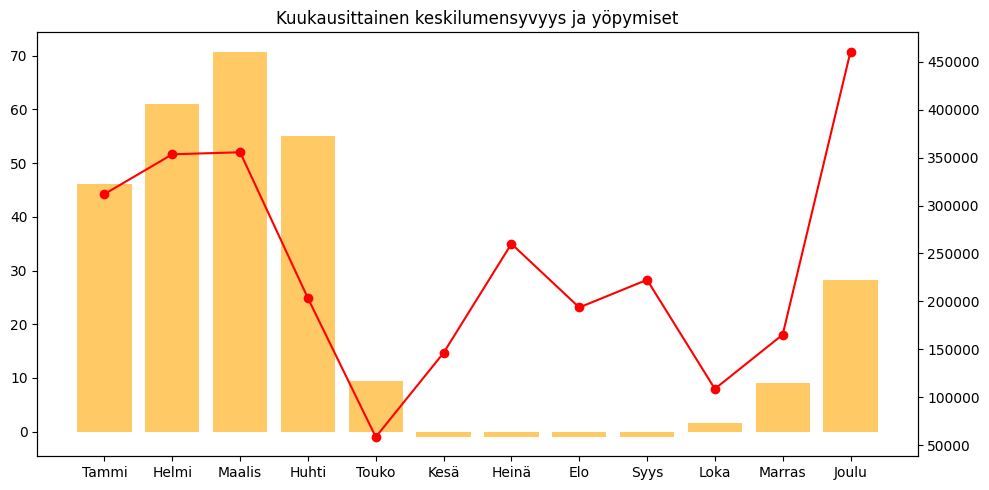

In [340]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(monthly_avg["Kuukausi_nimi"], monthly_avg["Lumensyvyys_keskiarvo"], color="orange", alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(monthly_avg["Kuukausi_nimi"], monthly_avg["Yhteensa"], color="red", marker="o")
plt.title("Kuukausittainen keskilumensyvyys ja yöpymiset")
fig.tight_layout()
plt.show()

### Visuaalisointi: Kuukausittaiset yöpymiset Suomessa ja ulkomailta tulleilta

Visualisoidaan kotimaisten ja ulkomaisten matkailijoiden yöpymiset kuukausitasolla.


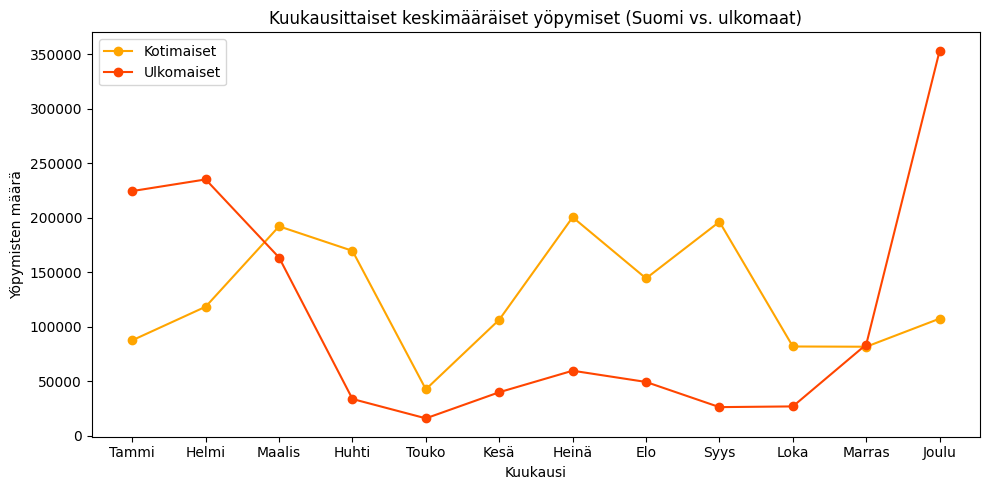

In [341]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg["Kuukausi_nimi"], monthly_avg["Yopymiset_Suomi"], marker="o", label="Kotimaiset", color="orange")
plt.plot(monthly_avg["Kuukausi_nimi"], monthly_avg["Yopymiset_Ulkomaat"], marker="o", label="Ulkomaiset", color="orangered")
plt.legend()
plt.title("Kuukausittaiset keskimääräiset yöpymiset (Suomi vs. ulkomaat)")
plt.ylabel("Yöpymisten määrä")
plt.xlabel("Kuukausi")
plt.tight_layout()
plt.show()


### Visuaalisointi: Vuodenaikojen keskilumensyvyys ja yöpymiset

Tarkastellaan vuodenajan mukaan lumensyvyyden ja yöpymisten yhteyttä.


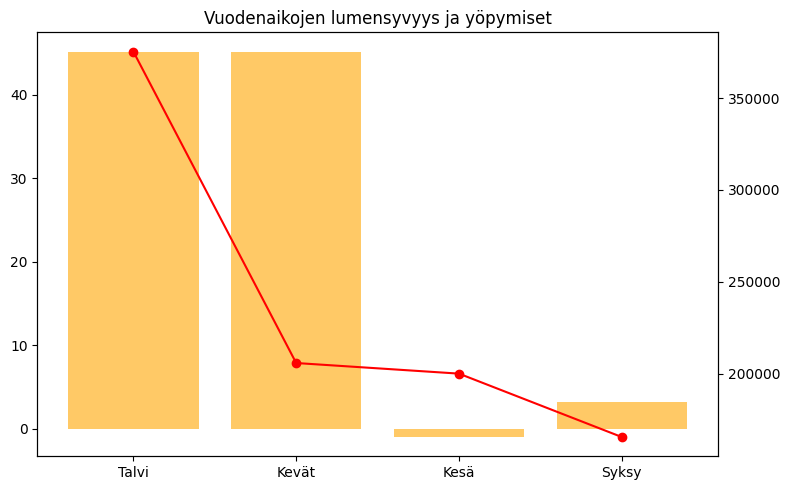

In [342]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.bar(seasonal_avg["Season"], seasonal_avg["Lumensyvyys_keskiarvo"], color="orange", alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(seasonal_avg["Season"], seasonal_avg["Yhteensa"], color="red", marker="o")
plt.title("Vuodenaikojen lumensyvyys ja yöpymiset")
fig.tight_layout()
plt.show()

### Visuaalisointi: Kotimaiset ja ulkomaiset yöpymiset eri vuodenaikoina

Vertailukaavio, joka näyttää eri vuodenaikojen keskimääräiset yöpymismäärät suomalaisille ja ulkomaalaisille.


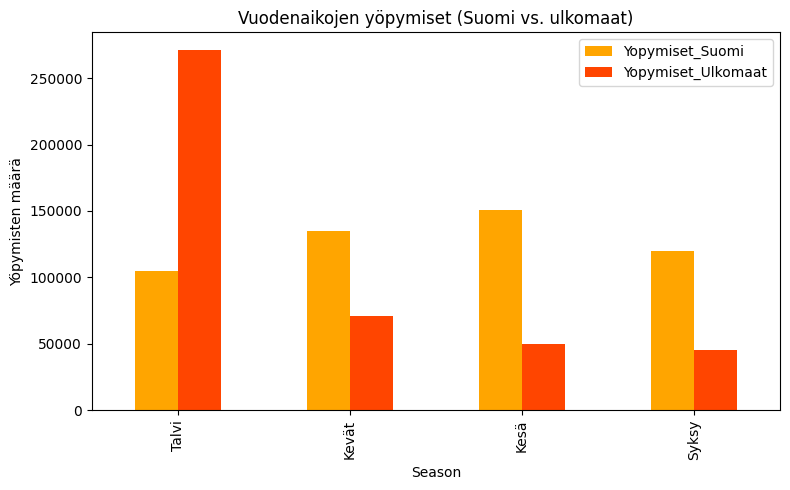

In [343]:
seasonal_avg.plot(
    x="Season",
    y=["Yopymiset_Suomi", "Yopymiset_Ulkomaat"],
    kind="bar",
    figsize=(8, 5),
    title="Vuodenaikojen yöpymiset (Suomi vs. ulkomaat)",
    color=["orange", "orangered"]
)
plt.ylabel("Yöpymisten määrä")
plt.tight_layout()
plt.show()


### Korrelaatioanalyysi: Lumensyvyys vs. yöpymiset

Lasketaan sekä kuukausi- että vuodenaikatasolla korrelaatiot lumensyvyyden ja yöpymisten välillä. Tuloksena saadaan selville, missä määrin lumi vaikuttaa matkailuun.


In [344]:
print("\n--- Korrelaatioanalyysi ---\n")
print("Kuukausitason korrelaatiomatriisi:\n")
print(monthly_avg.corr(numeric_only=True), "\n")

print("Vuodenaikojen keskiarvokorrelaatiot:\n")
print(seasonal_avg.corr(numeric_only=True), "\n")

print("--- Yhteenveto havainnoista ---")
print(f"Kuukausittainen korrelaatio lumi vs. ulkomaiset: {monthly_avg['Lumensyvyys_keskiarvo'].corr(monthly_avg['Yopymiset_Ulkomaat']):.2f}")
print(f"Kuukausittainen korrelaatio lumi vs. kotimaiset: {monthly_avg['Lumensyvyys_keskiarvo'].corr(monthly_avg['Yopymiset_Suomi']):.2f}")
print(f"Kuukausittainen korrelaatio lumi vs. yhteensä:   {monthly_avg['Lumensyvyys_keskiarvo'].corr(monthly_avg['Yhteensa']):.2f}")
print(f"Kausittainen korrelaatio lumi vs. ulkomaiset:   {seasonal_avg['Lumensyvyys_keskiarvo'].corr(seasonal_avg['Yopymiset_Ulkomaat']):.2f}")
print(f"Kausittainen korrelaatio lumi vs. kotimaiset:   {seasonal_avg['Lumensyvyys_keskiarvo'].corr(seasonal_avg['Yopymiset_Suomi']):.2f}")
print(f"Kausittainen korrelaatio lumi vs. yhteensä:     {seasonal_avg['Lumensyvyys_keskiarvo'].corr(seasonal_avg['Yhteensa']):.2f}")



--- Korrelaatioanalyysi ---

Kuukausitason korrelaatiomatriisi:

                       Lumensyvyys_keskiarvo  Yopymiset_Suomi  \
Lumensyvyys_keskiarvo               1.000000         0.157974   
Yopymiset_Suomi                     0.157974         1.000000   
Yopymiset_Ulkomaat                  0.557322        -0.100970   
Yhteensa                            0.594711         0.355923   

                       Yopymiset_Ulkomaat  Yhteensa  
Lumensyvyys_keskiarvo            0.557322  0.594711  
Yopymiset_Suomi                 -0.100970  0.355923  
Yopymiset_Ulkomaat               1.000000  0.893802  
Yhteensa                         0.893802  1.000000   

Vuodenaikojen keskiarvokorrelaatiot:

                       Lumensyvyys_keskiarvo  Yopymiset_Suomi  \
Lumensyvyys_keskiarvo               1.000000        -0.496955   
Yopymiset_Suomi                    -0.496955         1.000000   
Yopymiset_Ulkomaat                  0.655139        -0.762985   
Yhteensa                            0.

### Tilannekohtainen luokittelu: normaali, pandemia ja sota

Lisätään Tilanne sarake, joka luokittelee jokaisen havainnon sen perusteella, mihin ajanjaksoon se sijoittuu.

In [345]:
df_final["Tilanne"] = "Normaali"
df_final.loc[(df_final["Pvm"] >= "2020-01-01") & (df_final["Pvm"] <= "2022-12-31"), "Tilanne"] = "Pandemia"
df_final.loc[df_final["Pvm"] >= "2023-01-01", "Tilanne"] = "Sota"

### Keskiarvojen laskenta eri tilanteissa

Ryhmitellään data Tilanne sarakkeen mukaan (Normaali, Pandemia, Sota) ja lasketaan kullekin tilanteelle seuraavat keskiarvot:

- Kotimaiset yöpymiset
- Ulkomaiset yöpymiset
- Yöpymiset yhteensä
- Lumensyvyyden keskiarvo

Tämä mahdollistaa tilannekohtaisen vertailun matkailun ja sääolosuhteiden välillä.


In [346]:
tilanne_kooste = df_final.groupby("Tilanne").agg({
    "Yopymiset_Suomi": "mean",
    "Yopymiset_Ulkomaat": "mean",
    "Yhteensa": "mean",
    "Lumensyvyys_keskiarvo": "mean"
}).reset_index()

### Visualisointi: Yöpymisten keskiarvot tilannettain

Piirretään pylväskaavio, jossa verrataan kotimaisten ja ulkomaisten yöpymisten keskiarvoja eri tilanteissa: normaali, pandemia ja sota.


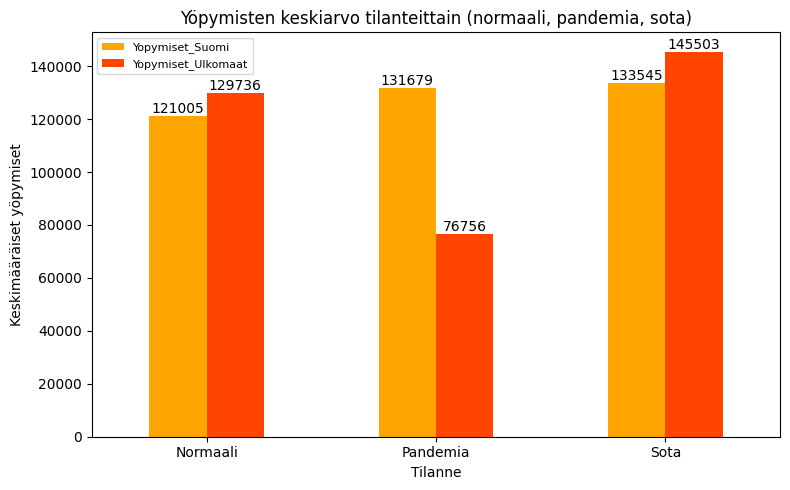

,Tilanne,Yopymiset_Suomi,Yopymiset_Ulkomaat,Yhteensa,Lumensyvyys_keskiarvo
0,Normaali,121005.416667,129736.027778,250741.444444,24.551871
1,Pandemia,131679.055556,76756.194444,208435.250000,21.527922
2,Sota,133544.583333,145502.916667,279047.500000,23.557773


In [ ]:
ax = tilanne_kooste.plot(
    x="Tilanne",
    y=["Yopymiset_Suomi", "Yopymiset_Ulkomaat"],
    kind="bar",
    figsize=(8, 5),
    title="Yöpymisten keskiarvo tilanteittain (normaali, pandemia, sota)",
    ylabel="Keskimääräiset yöpymiset",
    color=["orange", "orangered"]
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')
ax.legend(fontsize=8)  

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

tilanne_kooste
